In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.models import resnet18

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
device

device(type='cuda')

In [ ]:
transform = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

In [ ]:

train_dataset = torchvision.datasets.ImageFolder(root='/content/drive/MyDrive/BTP_new_dataset/train', transform=transform)
test_dataset = torchvision.datasets.ImageFolder(root='dataset/test', transform=transform)

In [ ]:
train_ratio = 0.8
train_size = int(train_ratio * len(train_dataset))
test_size = len(train_dataset) - train_size

train_set, val_set = torch.utils.data.random_split(train_dataset, [train_size, test_size])


train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
val_loader = DataLoader(val_set, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
class SelfAttention(nn.Module):
    def __init__(self, in_channels):
        super(SelfAttention, self).__init__()
        self.query_conv = nn.Conv2d(in_channels, in_channels//8, kernel_size=1)
        self.key_conv = nn.Conv2d(in_channels, in_channels//8, kernel_size=1)
        self.value_conv = nn.Conv2d(in_channels, in_channels, kernel_size=1)
        self.gamma = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        batch_size, C, width, height = x.size()
        proj_query = self.query_conv(x).view(batch_size, -1, width * height).permute(0, 2, 1)
        proj_key = self.key_conv(x).view(batch_size, -1, width * height)
        energy = torch.bmm(proj_query, proj_key)
        attention = torch.softmax(energy, dim=-1)
        proj_value = self.value_conv(x).view(batch_size, -1, width * height)

        out = torch.bmm(proj_value, attention.permute(0, 2, 1))
        out = out.view(batch_size, C, width, height)

        out = self.gamma * out + x
        return out


class NETWithAttentionAndClassifier(nn.Module):
    def __init__(self, pretrained_model, num_classes, channel):
        super(NETWithAttentionAndClassifier, self).__init__()
        self.resnet = nn.Sequential(*list(pretrained_model.children())[:-2])
        self.attention = SelfAttention(channel)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(channel, num_classes)

    def forward(self, x):
        x = self.resnet(x)
        x = self.attention(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x


model = NETWithAttentionAndClassifier(resnet18(pretrained=True), num_classes=10, channel=512)
model
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 133MB/s]


In [ ]:
model_path = '/content/drive/MyDrive/resnet_with_attention.pth'
my_model = model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
#model=torch.load(model_path,map_location=torch.device('cpu'))

In [ ]:
import numpy as np

model.to(device)
lossfun = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(),lr=0.001,momentum=0.9)
epoch=0


numepochs = 20

# initialize losses
trainLoss = torch.zeros(numepochs)
testLoss  = torch.zeros(numepochs)

trainAcc  = torch.zeros(numepochs)
testAcc   = torch.zeros(numepochs)

# loop over epochs
for epochi in range(epoch,numepochs):

    # loop over training data batches
    model.train() # switch to train mode
    batchLoss = []
    batchAcc  = []
    for X,y in train_loader:

      # push data to GPU
      X = X.to(device)
      y = y.to(device)

      # forward pass and loss
      yHat = model(X).to(device)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss and accuracy from this batch
      batchLoss.append(loss.item())

      batchAcc.append( torch.mean((torch.argmax(yHat,axis=1) == y).float()).item() )
    # end of batch loop...

    # and get average losses and accuracies across the batches
    trainLoss[epochi] = np.mean(batchLoss)

    trainAcc[epochi]  = 100*np.mean(batchAcc)


    #### test performance (here done in batches!)
    model.eval() # switch to test mode
    batchAcc  = []
    batchLoss = []
    for X,y in test_loader:

      # push data to GPU
      X = X.to(device)
      y = y.to(device)

      # forward pass and loss
      with torch.no_grad():
        yHat = model(X).to(device)
        loss = lossfun(yHat,y)

      # loss and accuracy from this batch
      batchLoss.append(loss.item())
      batchAcc.append( torch.mean((torch.argmax(yHat,axis=1) == y).float()).item() )
    # end of batch loop...

    # and get average losses and accuracies across the batches
    testLoss[epochi] = np.mean(batchLoss)
    testAcc[epochi]  = 100*np.mean(batchAcc)

    # print out a status update
    print(f'Finished epoch {epochi+1}/{numepochs}. Train accuracy = {trainAcc[epochi]:.2f}, Test accuracy = {testAcc[epochi]:.2f}%')

Finished epoch 1/20. Train accuracy = 93.28, Test accuracy = 98.72%
Finished epoch 2/20. Train accuracy = 98.58, Test accuracy = 99.29%
Finished epoch 3/20. Train accuracy = 99.26, Test accuracy = 99.50%
Finished epoch 4/20. Train accuracy = 99.44, Test accuracy = 99.64%
Finished epoch 5/20. Train accuracy = 99.67, Test accuracy = 99.72%
Finished epoch 6/20. Train accuracy = 99.62, Test accuracy = 99.74%
Finished epoch 7/20. Train accuracy = 99.72, Test accuracy = 99.83%
Finished epoch 8/20. Train accuracy = 99.86, Test accuracy = 99.86%
Finished epoch 9/20. Train accuracy = 99.86, Test accuracy = 99.86%
Finished epoch 10/20. Train accuracy = 99.88, Test accuracy = 99.76%
Finished epoch 11/20. Train accuracy = 99.88, Test accuracy = 99.83%
Finished epoch 12/20. Train accuracy = 99.93, Test accuracy = 99.83%
Finished epoch 13/20. Train accuracy = 99.89, Test accuracy = 99.88%
Finished epoch 14/20. Train accuracy = 99.91, Test accuracy = 99.86%
Finished epoch 15/20. Train accuracy = 99.9

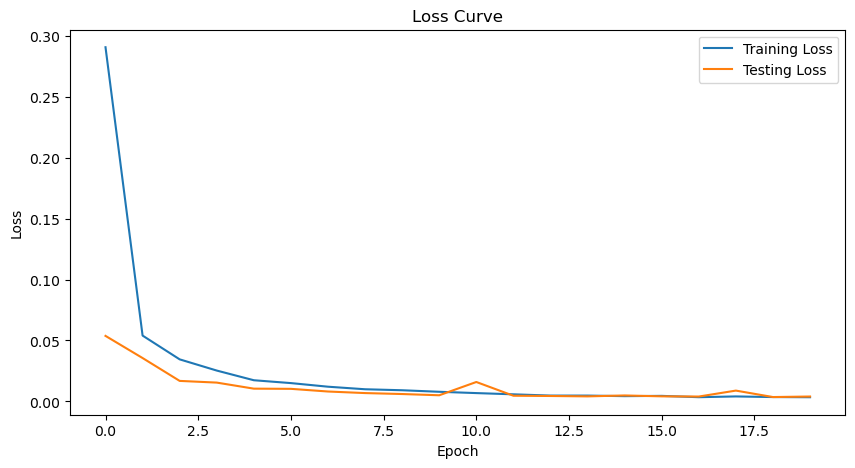

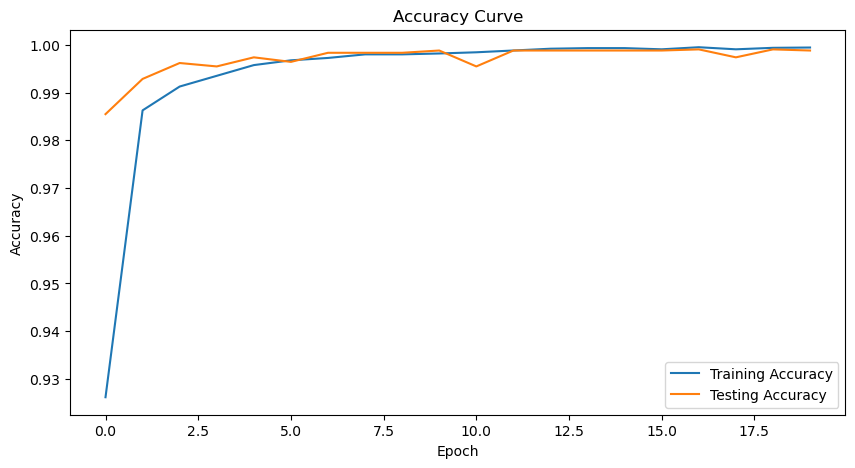

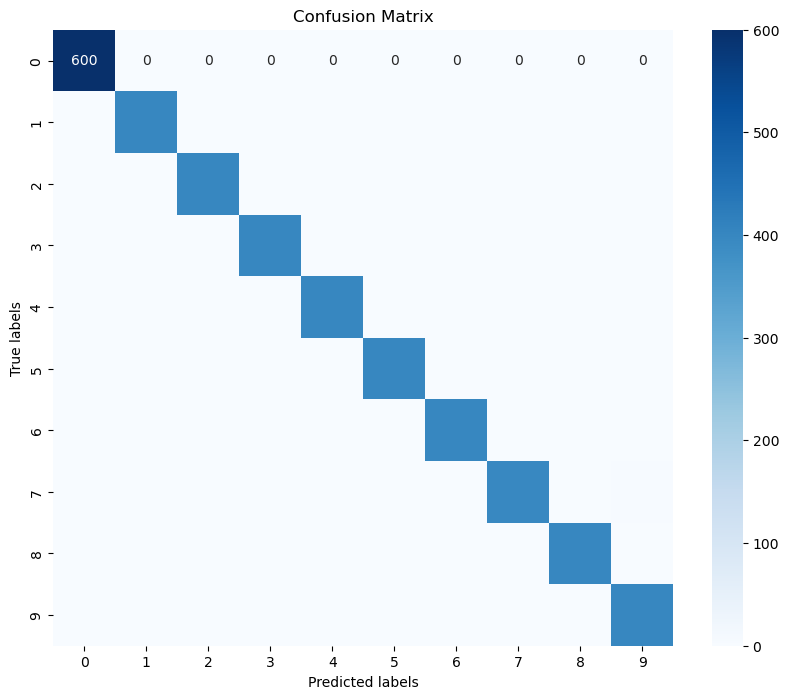

In [ ]:
import numpy as np
import torch
import torch.nn as nn
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you have defined your device and dataloaders (train_loader and test_loader) previously

# Move model to device
model.to(device)

# Define loss function and optimizer
lossfun = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Initialize lists to store metrics
num_epochs = 20
train_loss_list, test_loss_list = [], []
train_acc_list, test_acc_list = [], []
predictions_list, true_labels_list = [], []

# Loop over epochs
for epoch in range(num_epochs):

    # Train the model
    model.train()
    train_loss, correct_train = 0, 0
    total_train = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = lossfun(outputs, labels)
        loss.backward()
        optimizer.step()
        _, predicted = torch.max(outputs, 1)
        train_loss += loss.item()
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    # Calculate training loss and accuracy
    train_loss_list.append(train_loss / len(train_loader))
    train_acc_list.append(correct_train / total_train)

    # Evaluate the model on test data
    model.eval()
    test_loss, correct_test = 0, 0
    total_test = 0
    predictions, true_labels = [], []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = lossfun(outputs, labels)
            _, predicted = torch.max(outputs, 1)
            test_loss += loss.item()
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()
            predictions.extend(predicted.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    # Calculate testing loss and accuracy
    test_loss_list.append(test_loss / len(test_loader))
    test_acc_list.append(correct_test / total_test)

# Plot loss curve versus epoch
plt.figure(figsize=(10, 5))
plt.plot(train_loss_list, label='Training Loss')
plt.plot(test_loss_list, label='Testing Loss')
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot accuracy curve versus epoch
plt.figure(figsize=(10, 5))
plt.plot(train_acc_list, label='Training Accuracy')
plt.plot(test_acc_list, label='Testing Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot confusion matrix
conf_matrix = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
torch.save(model.state_dict()                                                                                                                                                                                                                                                                                                                                               , 'resnet_with_attention.pth')

In [ ]:
model_path = '/content/drive/MyDrive/resnet_with_attention.pth'
my_model = model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))

In [ ]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs, labels  # Move data to GPU
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Test Accuracy: {100 * correct / total:.2f}%")

Test Accuracy: 99.95%


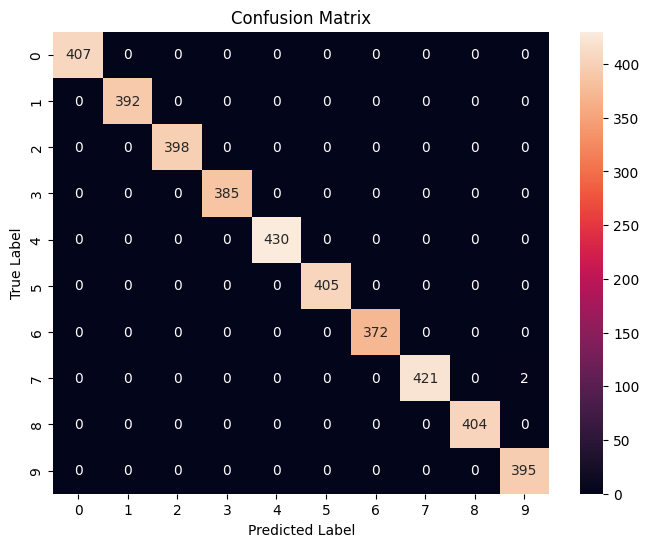

In [ ]:
import numpy as np
import seaborn as sns
predictions = np.array(predictions)
true_labels = np.array(true_labels)

accuracy = np.mean(predictions == true_labels)
error = 1 - accuracy



# Step 5: Plot Confusion Matrix
conf_matrix = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(8, 6))

sns.heatmap(conf_matrix,
            annot=True,
            fmt='g')

plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()